# New York AirBnB Data
Using the NewYork data - useful facts about the data:

Two datsets used: listings.csv and calendar.csv

Business Questions (Business Understanding)
<b><li>What are the most common Airbnb property types in New York available for renting?What is the availability of the properties throughout the year?</li></b> 

<b><li>What is the average pricing of the properties for renting?Are there any seasonal spiking in pricing of the properties?</li></b> 

<b><li>What are the most common streets in New York for Airbnb properties? What are most costliest streets in New York? Does the neighborhood group affect the pricing of the properties?</li></b> 

<b><li>Can we use some of the features in the listing data to predict property pricing?What are the most important factors affecting the cost of the properties?</li></b> 

First, let's read in the necessary libraries and datasets.

In [74]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error,median_absolute_error, r2_score,mean_squared_error
from sklearn.tree import DecisionTreeRegressor 
from sklearn.ensemble import AdaBoostRegressor,GradientBoostingRegressor 
from sklearn import preprocessing
%matplotlib inline

In [75]:
listings = pd.read_csv('listings.csv')
calendar = pd.read_csv('calendar.csv')

C:\Users\DELL\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (61,62,94,95) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Little data wrangling and cleaning here, to prepare the data for analysis 

In [76]:
listings.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,3647,https://www.airbnb.com/rooms/3647,20190912153101,2019-09-13,THE VILLAGE OF HARLEM....NEW YORK !,NaN,WELCOME TO OUR INTERNATIONAL URBAN COMMUNITY T...,WELCOME TO OUR INTERNATIONAL URBAN COMMUNITY T...,none,NaN,...,f,f,strict_14_with_grace_period,t,t,1,0,1,0,NaN
1,3831,https://www.airbnb.com/rooms/3831,20190912153101,2019-09-13,Cozy Entire Floor of Brownstone,Urban retreat: enjoy 500 s.f. floor in 1899 br...,Greetings! We own a double-duplex brownst...,Urban retreat: enjoy 500 s.f. floor in 1899 br...,none,Just the right mix of urban center and local n...,...,f,f,moderate,f,f,1,1,0,0,4.62
2,5022,https://www.airbnb.com/rooms/5022,20190912153101,2019-09-13,Entire Apt: Spacious Studio/Loft by central park,NaN,Loft apartment with high ceiling and wood floo...,Loft apartment with high ceiling and wood floo...,none,NaN,...,f,f,strict_14_with_grace_period,t,t,1,1,0,0,0.10
3,5099,https://www.airbnb.com/rooms/5099,20190912153101,2019-09-13,Large Cozy 1 BR Apartment In Midtown East,My large 1 bedroom apartment has a true New Yo...,I have a large 1 bedroom apartment centrally l...,My large 1 bedroom apartment has a true New Yo...,none,My neighborhood in Midtown East is called Murr...,...,f,f,moderate,t,t,1,1,0,0,0.59
4,5121,https://www.airbnb.com/rooms/5121,20190912153101,2019-09-13,BlissArtsSpace!,NaN,HELLO EVERYONE AND THANKS FOR VISITING BLISS A...,HELLO EVERYONE AND THANKS FOR VISITING BLISS A...,none,NaN,...,f,f,strict_14_with_grace_period,f,f,1,0,1,0,0.39


In [77]:
# removing columns which has only one unique value in the column as that column would be not usefull for analysis 
for col in listings:
    if listings[col].value_counts().count() <= 1:
        listings = listings.drop(col, axis = 1)

In [78]:
# dropping columns which has 60% of values missing
for col in listings:
        percentage = int(listings[col].isna().sum() / listings.shape[0] * 100)
        if percentage > 60:
            listings = listings.drop(col, axis=1)

In [79]:
listings.price.dtype

dtype('O')

In [80]:
# converting price into float
listings['price'] = listings['price'].apply(lambda x: float(str(x).replace('$', '').replace(',', '')))
calendar['price'] = calendar['price'].apply(lambda x: float(str(x).replace('$', '').replace(',', '')))

In [81]:
calendar['date'].head()

0    2019-09-13
1    2019-09-13
2    2019-09-14
3    2019-09-15
4    2019-09-16
Name: date, dtype: object

In [82]:
# adding a new column Year-Month to do the monthly analysis of the data
calendar['Year-Month'] = calendar['date'].apply(lambda x:(str(x).replace(x, x[0:7])))
calendar.head()

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights,Year-Month
0,9668,2019-09-13,f,51.0,$51.00,3.0,365.0,2019-09
1,26969,2019-09-13,f,350.0,$350.00,3.0,33.0,2019-09
2,26969,2019-09-14,f,350.0,$350.00,3.0,33.0,2019-09
3,26969,2019-09-15,f,350.0,$350.00,3.0,33.0,2019-09
4,26969,2019-09-16,f,350.0,$350.00,3.0,33.0,2019-09


In [83]:
calendar.available.dtype

dtype('O')

In [84]:
# converting the column "available" into boolean for performing operations
calendar.available.replace('f', False, inplace=True)
calendar.available.replace('t', True, inplace=True)
calendar.head()

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights,Year-Month
0,9668,2019-09-13,False,51.0,$51.00,3.0,365.0,2019-09
1,26969,2019-09-13,False,350.0,$350.00,3.0,33.0,2019-09
2,26969,2019-09-14,False,350.0,$350.00,3.0,33.0,2019-09
3,26969,2019-09-15,False,350.0,$350.00,3.0,33.0,2019-09
4,26969,2019-09-16,False,350.0,$350.00,3.0,33.0,2019-09


<h1><b>1)What are the most common Airbnb property types in New York available for renting?What is the availability of the properties throughout the year?</b></h1>

In [85]:
# grouping the property types according to their frequency
common_properties = listings.groupby('property_type').count()['id'].reset_index().sort_values(by='id',ascending=False).head(9)
common_properties

,property_type,id
1,Apartment,38144
22,House,3944
33,Townhouse,1624
13,Condominium,1512
25,Loft,1375
29,Serviced apartment,437
18,Guest suite,382
21,Hotel,219
5,Boutique hotel,214


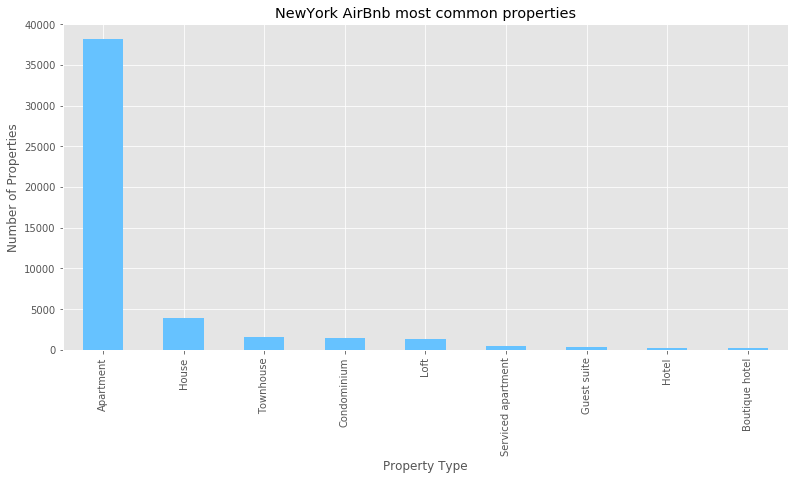

In [86]:
# plotting the data of the table above
plt.style.use('ggplot');

common_properties.plot(kind='bar', 
           x='property_type',
           y='id',
           color = '#66c2ff', 
           figsize =(13,6), 
           title = "NewYork AirBnb most common properties", 
           legend = False);
plt.xlabel('Property Type');
plt.ylabel('Number of Properties');

Not surprisingly, Apartments and Houses take up an overwhelming majority of all listings followed by Townhouse and Condominium.There are total 36 types of properties available for renting in New York out of which, the property types displayed in the graph above have the maximum listings.

In [87]:
# grouping the availibilty of the properties according to the months.
property_availability = calendar.groupby('Year-Month').mean()['available'].reset_index()
property_availability

,Year-Month,available
0,2019-09,0.136140
1,2019-10,0.251666
2,2019-11,0.368903
3,2019-12,0.347781
4,2020-01,0.385394
5,2020-02,0.400951
6,2020-03,0.339227
7,2020-04,0.301791
8,2020-05,0.306313
9,2020-06,0.293220


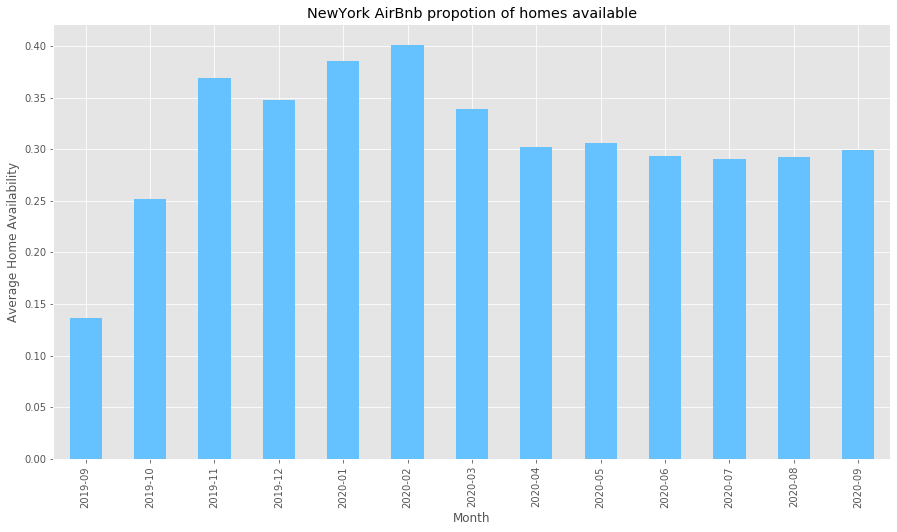

In [88]:
# plotting the data for the above table
property_availability.plot(kind='bar', 
           x='Year-Month',
           y='available',
           color = '#66c2ff', 
           figsize =(15,8), 
           title = "NewYork AirBnb propotion of homes available", 
           legend = False);
plt.xlabel('Month');
plt.ylabel('Average Home Availability');

The highest availability of Airbnb homes will be on February 2020 with 40% of properties available for renting while lowest availability was observed on September2019 with just 10–15% of homes available. The availability largely increased after September2019. There will be quite a dip of 10% in the available after February2020. There won’t be major ups and downs in the availability after February with the range of availability lying in 25–32%.

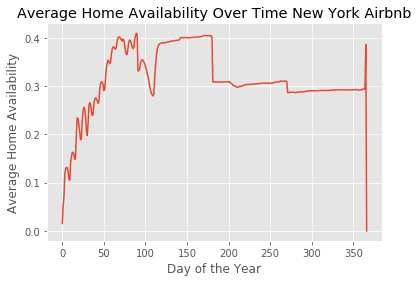

In [89]:
# Analysing the home availability on each single day of the year
homes_perday = calendar.groupby('date').mean()['available'].reset_index()
plt.plot(homes_perday['available']);
plt.title('Average Home Availability Over Time New York Airbnb');
plt.xlabel('Day of the Year');
plt.ylabel('Average Home Availability');

Day-1 corresponds to 09/12/2019 and Day-360 corresponds to 09/11/2020.

<b><h1>2)What is the average pricing of the properties for renting?Are there any seasonal spiking in pricing of the properties?</b></h1>

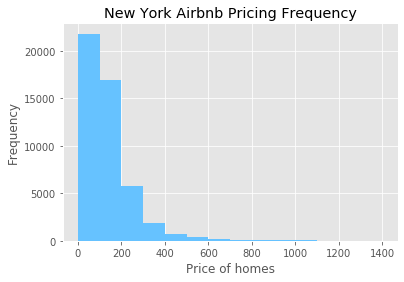

In [91]:
# plotting frequency of the pricing in the data
plt.hist(data = listings , x='price',color = '#66c2ff', bins=np.arange(0,1500,100));
plt.title('New York Airbnb Pricing Frequency');
plt.xlabel('Price of homes');
plt.ylabel('Frequency');

Most of the properties fall in the range of 0–200 dollars.As the price increases you can see the dip in frequency of the homes.The average pricing of homes in New York around 152 dollars while median and highest pricing is around 105 dollars and  10,000 dollars.

In [92]:
# grouping the prices according to the months to analyse seasonal spiking
seasonal_prices = calendar.groupby('Year-Month').mean()['price'].reset_index()
seasonal_prices

,Year-Month,price
0,2019-09,154.105371
1,2019-10,155.069442
2,2019-11,153.674227
3,2019-12,162.362288
4,2020-01,154.183088
5,2020-02,150.509281
6,2020-03,153.912157
7,2020-04,157.030554
8,2020-05,158.401121
9,2020-06,157.476664


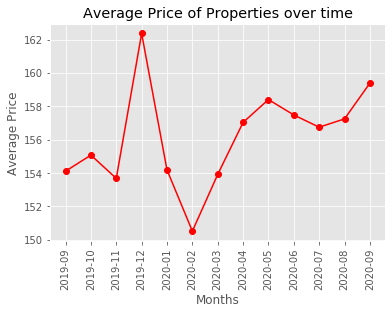

In [93]:
# plotting the price trends over months
x=seasonal_prices['Year-Month'].tolist()
y=seasonal_prices['price'].tolist()
plt.plot(x,y,'ro-')
plt.ylabel('Average Price')
plt.xlabel('Months')
plt.title('Average Price of Properties over time')
plt.xticks(rotation=90)
plt.show();

Similar to availability, we can also see how listings prices change over time. The highest average property price will be on the December-2019 ranging just above $162. The lowest would observe on February-2020, due to the highest availability of the homes in that period. A huge downfall of the pricing will be observed after December lasting till February-2020. After which price tends to rise till April-2020. There won’t be a major fluctuation in the pricing from April-2020 to September-2020.

In [94]:
# grouping the prices according to the days to analyse seasonal spiking
seasonal_prices_days = calendar.groupby('date').mean()['price'].reset_index()
seasonal_prices_days

,date,price
0,2019-09-12,127.187340
1,2019-09-13,155.549995
2,2019-09-14,156.315694
3,2019-09-15,151.762072
4,2019-09-16,152.233318
...,...,...
362,2020-09-08,157.293569
363,2020-09-09,157.951692
364,2020-09-10,158.118197
365,2020-09-11,170.466983


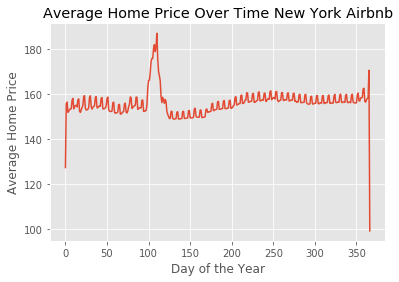

In [95]:
# Analysing the home prices on each single day of the year
plt.plot(seasonal_prices_days['price']);
plt.title('Average Home Price Over Time New York Airbnb');
plt.xlabel('Day of the Year');
plt.ylabel('Average Home Price');

Day-1 corresponds to 09/12/2019 and Day-360 corresponds to 09/11/2020.

<h1><b>3)What are the most common streets in New York for Airbnb properties? What are most costliest streets in New York? Does the neighborhood group affect the pricing of the properties?</b></h1> 

In [96]:
# grouping streets according to their frequency and displaying top3 streets
street=listings.groupby(['street']).count()['id'].reset_index().sort_values(by='id',ascending = False).head(4)
street.rename(columns={'id':'Number of Properties'})

,street,Number of Properties
190,"New York, NY, United States",21451
59,"Brooklyn, NY, United States",18758
225,"Queens, NY, United States",4519
39,"Bronx, NY, United States",756


New York and Brooklyn street has the highest number of homes for renting followed by Queens and Bronx.

In [97]:
streets = listings.groupby('street').price.mean().reset_index().sort_values(by='price',ascending = False).head(5)
streets

,street,price
113,"Forest Hills , NY, United States",1005.333333
74,"Chelsea, New York, NY, United States",800.000000
187,"New York City, NY, United States",423.631579
277,"US, United States",421.000000
209,"PRINCE, NY, United States",418.000000


Forest Hills and Chelsea dominate the pricing of the properties in New York with average pricing for them ranging 1005 dollars and 800 dollars respectively.

In [98]:
listings.loc[listings['street'] == 'Forest Hills , NY, United States']['property_type']

17071    Apartment
35280    Apartment
44312        House
Name: property_type, dtype: object

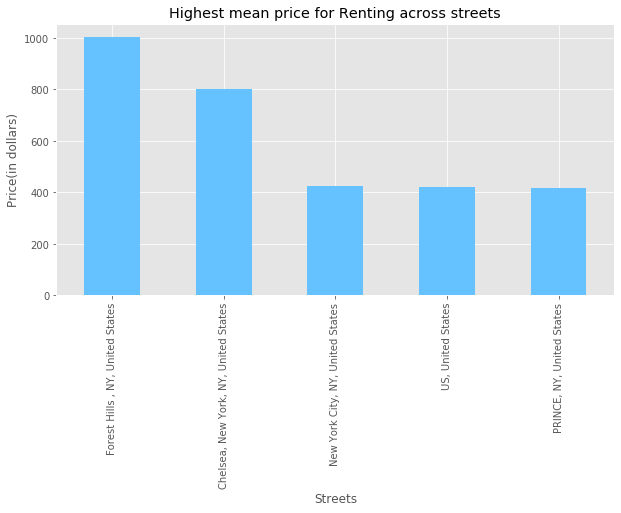

In [99]:
# plotting the data for the above table
streets.plot(kind='bar', 
           x='street',
           y='price',
           color = '#66c2ff', 
           figsize =(10,5), 
           title = "Highest mean price for Renting across streets", 
           legend = False);
plt.xlabel('Streets');
plt.ylabel('Price(in dollars)');

In [100]:
# grouping neighborhood groups according to their price
neighborhood = listings.groupby('neighbourhood_group_cleansed').price.mean().reset_index()

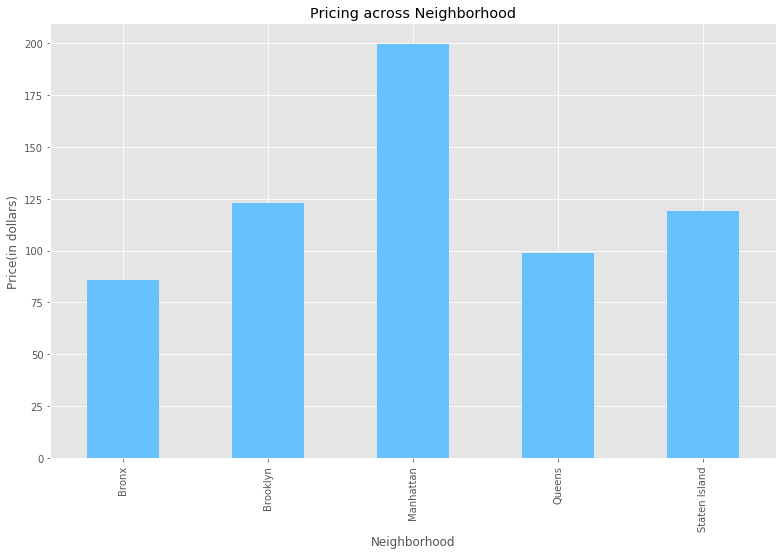

In [101]:
# plotting the data for the above table
neighborhood.plot(kind='bar', 
           x='neighbourhood_group_cleansed',
           y='price',
           color = '#66c2ff', 
           figsize =(13,8), 
           title = "Pricing across Neighborhood", 
           legend = False);
plt.xlabel('Neighborhood');
plt.ylabel('Price(in dollars)');

Manhattan is the costliest neighborhood for Airbnb properties with average pricing ranging at 200 dollars. Bronx seems to be cheapest with the average pricing at approximately 80 dollars. Brooklyn, Queens and State Island are lying at the affordable pricing of  100-125 dollars.

<h1><b>4)Can we use some of the features in the listing data to predict property pricing?What are the most important factors affecting the cost of the properties?</b></h1>

Data cleaning and feature selection for ML model.


In [102]:
# selecting the features for model
df = listings[['latitude','longitude','minimum_nights','number_of_reviews','reviews_per_month',
              'calculated_host_listings_count','availability_365','property_type',
             'room_type','neighbourhood_group_cleansed','host_is_superhost','host_listings_count',
             'host_has_profile_pic','host_identity_verified','is_location_exact','accommodates',
              'bedrooms','guests_included','require_guest_phone_verification','require_guest_profile_picture',
              'review_scores_value','cancellation_policy','price']]

In [103]:
df.head()

,latitude,longitude,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,property_type,room_type,neighbourhood_group_cleansed,...,host_identity_verified,is_location_exact,accommodates,bedrooms,guests_included,require_guest_phone_verification,require_guest_profile_picture,review_scores_value,cancellation_policy,price
0,40.80902,-73.94190,3,0,NaN,1,365,Apartment,Private room,Manhattan,...,t,t,2,1.0,2,t,t,NaN,strict_14_with_grace_period,150.0
1,40.68514,-73.95976,1,279,4.62,1,192,Guest suite,Entire home/apt,Brooklyn,...,t,t,3,1.0,1,f,f,9.0,moderate,89.0
2,40.79851,-73.94399,10,9,0.10,1,0,Apartment,Entire home/apt,Manhattan,...,t,t,1,NaN,1,t,t,10.0,strict_14_with_grace_period,80.0
3,40.74767,-73.97500,3,75,0.59,1,13,Apartment,Entire home/apt,Manhattan,...,f,f,2,1.0,2,t,t,9.0,moderate,200.0
4,40.68688,-73.95596,45,49,0.39,1,0,Apartment,Private room,Brooklyn,...,f,f,2,1.0,1,f,f,9.0,strict_14_with_grace_period,60.0


In [104]:
df.isna().sum()

latitude                                0
longitude                               0
minimum_nights                          0
number_of_reviews                       0
reviews_per_month                    9651
calculated_host_listings_count          0
availability_365                        0
property_type                           0
room_type                               0
neighbourhood_group_cleansed            0
host_is_superhost                      21
host_listings_count                    21
host_has_profile_pic                   21
host_identity_verified                 21
is_location_exact                       0
accommodates                            0
bedrooms                               41
guests_included                         0
require_guest_phone_verification        0
require_guest_profile_picture           0
review_scores_value                 10618
cancellation_policy                     0
price                                   0
dtype: int64

In [105]:
# filling missing values in the column by mean and median of that column
df['reviews_per_month'] = df['reviews_per_month'].fillna(df['reviews_per_month'].mean())
df['host_is_superhost'] = df['host_is_superhost'].fillna(df['host_is_superhost'].mode()[0] )
df['review_scores_value'] = df['review_scores_value'].fillna(df['review_scores_value'].mean() )
df['host_listings_count'] = df['host_listings_count'].fillna(df['host_listings_count'].mean())
df['bedrooms'] = df['bedrooms'].fillna(df['bedrooms'].mode()[0] )
df['host_has_profile_pic'] = df['host_has_profile_pic'].fillna(df['host_has_profile_pic'].mode()[0] )
df['host_identity_verified'] = df['host_identity_verified'].fillna(df['host_identity_verified'].mode()[0])

C:\Users\DELL\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\DELL\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\DELL\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

In [106]:
# converting the true and false columns into 0 and 1.
df.is_location_exact.replace('f', 0, inplace=True)
df.is_location_exact.replace('t', 1, inplace=True)
df.require_guest_profile_picture.replace('f', 0, inplace=True)
df.require_guest_profile_picture.replace('t', 1, inplace=True)
df.require_guest_phone_verification.replace('f', 0, inplace=True)
df.require_guest_phone_verification.replace('t', 1, inplace=True)
df.host_identity_verified.replace('f', 0, inplace=True)
df.host_identity_verified.replace('t', 1, inplace=True)
df.host_has_profile_pic.replace('f', 0, inplace=True)
df.host_has_profile_pic.replace('t', 1, inplace=True)
df.host_is_superhost.replace('f', 0, inplace=True)
df.host_is_superhost.replace('t', 1, inplace=True)

C:\Users\DELL\Anaconda3\lib\site-packages\pandas\core\generic.py:6786: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


In [107]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48377 entries, 0 to 48376
Data columns (total 23 columns):
latitude                            48377 non-null float64
longitude                           48377 non-null float64
minimum_nights                      48377 non-null int64
number_of_reviews                   48377 non-null int64
reviews_per_month                   48377 non-null float64
calculated_host_listings_count      48377 non-null int64
availability_365                    48377 non-null int64
property_type                       48377 non-null object
room_type                           48377 non-null object
neighbourhood_group_cleansed        48377 non-null object
host_is_superhost                   48377 non-null int64
host_listings_count                 48377 non-null float64
host_has_profile_pic                48377 non-null int64
host_identity_verified              48377 non-null int64
is_location_exact                   48377 non-null int64
accommodates             

In [108]:
# Encoding catergorical variables into numbers
le = preprocessing.LabelEncoder()
df['property_type'] = le.fit_transform(df['property_type'])
df['room_type'] = le.fit_transform(df['room_type'])
df['neighbourhood_group_cleansed'] = le.fit_transform(df['neighbourhood_group_cleansed'])
df['cancellation_policy'] = le.fit_transform(df['cancellation_policy'])

C:\Users\DELL\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\DELL\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\DELL\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .

In [109]:
df.head()

,latitude,longitude,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,property_type,room_type,neighbourhood_group_cleansed,...,host_identity_verified,is_location_exact,accommodates,bedrooms,guests_included,require_guest_phone_verification,require_guest_profile_picture,review_scores_value,cancellation_policy,price
0,40.80902,-73.94190,3,0,1.385109,1,365,1,2,2,...,1,1,2,1.0,2,1,1,9.392701,3,150.0
1,40.68514,-73.95976,1,279,4.620000,1,192,18,0,1,...,1,1,3,1.0,1,0,0,9.000000,1,89.0
2,40.79851,-73.94399,10,9,0.100000,1,0,1,0,2,...,1,1,1,1.0,1,1,1,10.000000,3,80.0
3,40.74767,-73.97500,3,75,0.590000,1,13,1,0,2,...,0,0,2,1.0,2,1,1,9.000000,1,200.0
4,40.68688,-73.95596,45,49,0.390000,1,0,1,2,1,...,0,0,2,1.0,1,0,0,9.000000,3,60.0


In [110]:
df.price.describe()

count    48377.000000
mean       152.659549
std        258.284567
min          0.000000
25%         69.000000
50%        105.000000
75%        175.000000
max      10000.000000
Name: price, dtype: float64

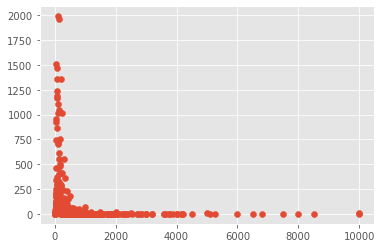

In [111]:
# exploring outliers in the price
outliers_explore = listings.groupby('price').id.count().reset_index()
plt.scatter(y='id', x='price', data = outliers_explore);
plt.show();

In [112]:
#exploring outliers
df.loc[df['price'] > 600].count()

latitude                            732
longitude                           732
minimum_nights                      732
number_of_reviews                   732
reviews_per_month                   732
calculated_host_listings_count      732
availability_365                    732
property_type                       732
room_type                           732
neighbourhood_group_cleansed        732
host_is_superhost                   732
host_listings_count                 732
host_has_profile_pic                732
host_identity_verified              732
is_location_exact                   732
accommodates                        732
bedrooms                            732
guests_included                     732
require_guest_phone_verification    732
require_guest_profile_picture       732
review_scores_value                 732
cancellation_policy                 732
price                               732
dtype: int64

In [113]:
# droping extreme outliers by selecting only prices less than $600
df = df.loc[df['price'] < 600]

In [114]:
# assigning the input and target 
X = df.drop('price',axis=1)
y = df[['price']]

In [115]:
# scaling the data using StandardScaler 
scaler = preprocessing.StandardScaler().fit(X)
X_scaled = scaler.transform(X)

In [116]:
# spliting the data into train and test set
X_train, X_test, y_train, y_test = train_test_split(X_scaled,y.values ,test_size=0.4, random_state=42)

In [117]:
#Instantiating GradientBosstingRegressor
bc = GradientBoostingRegressor(n_estimators=100, max_depth=11, random_state=1, subsample=1, max_features=0.3) 

In [118]:
# fitting the data on train set and predicting on test set
bc.fit(X_train , y_train)
y_pred=bc.predict(X_test)

C:\Users\DELL\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [119]:
median_absolute_error(y_pred,y_test)

20.699336159141538

In [120]:
mean_absolute_error(y_pred,y_test)

33.49582804296291

Median absolute error is considered here because of the outliers present in the data which are affecting the prices.

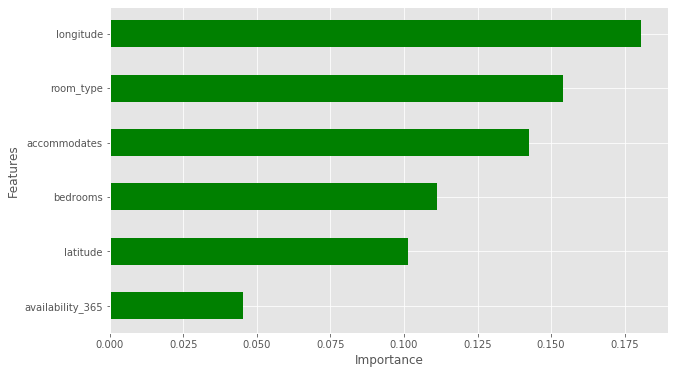

In [121]:
importances_rf = pd.Series(bc.feature_importances_, index = X.columns) 
sorted_importances_rf = importances_rf.sort_values().tail(6)
sorted_importances_rf.plot(kind='barh', color='green', figsize=(10,6)); 
plt.xlabel('Importance');
plt.ylabel('Features');
plt.show(); 

Longitude and Lattitude turns out to be most important factors affecting the prices followed by room type and accommodates

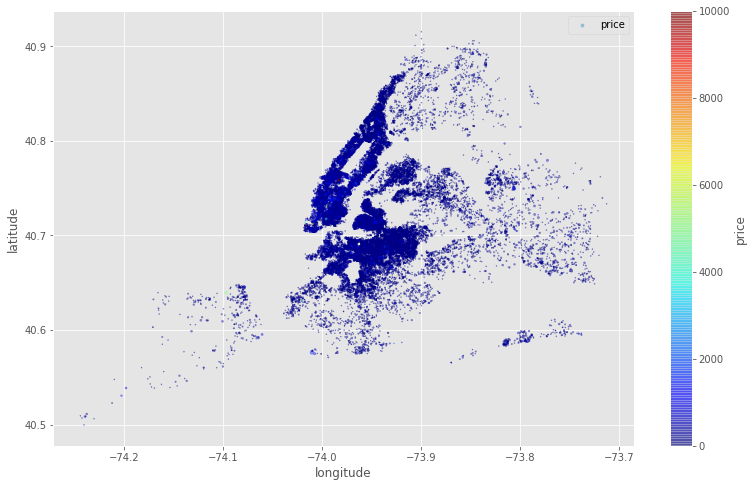

In [122]:
# plotting the price distribution across the city using longitudes and latitudes
listings.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
    s=listings['bedrooms'], label="price", figsize=(13,8),
    c="price", colorbar=True,cmap=plt.get_cmap("jet"),
    sharex=False);
plt.legend();

Here is the little insight into prices across NewYork

In [123]:
room_type = listings.groupby('room_type').mean()['price'].reset_index()

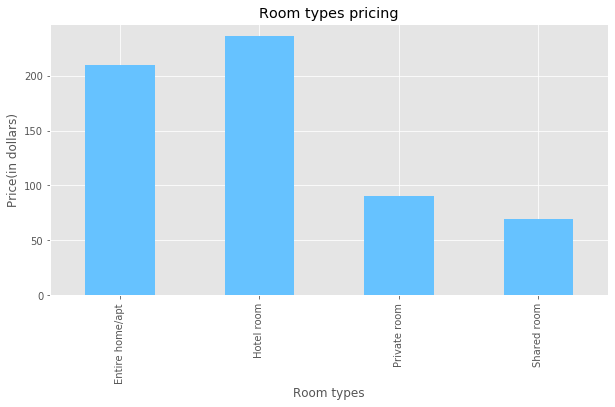

In [124]:
room_type.plot(kind='bar', 
           x='room_type',
           y='price',
           color = '#66c2ff', 
           figsize =(10,5), 
           title = "Room types pricing", 
           legend = False);
plt.xlabel('Room types');
plt.ylabel('Price(in dollars)');

Average pricing according to the room types